<a href="https://colab.research.google.com/github/julianoks/metric_learning_demo/blob/master/metric_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Hyperparameters
learning_rate_coeff = 5 #@param {type:"slider", min:1, max:9, step:1}
learning_rate_exponent = -4 #@param {type:"slider", min:-5, max:0, step:1}
learning_rate = learning_rate_coeff*(10 ** learning_rate_exponent)

keep_prob_dropout = 0.75 #@param {type:"slider", min:0, max:1, step:0.05}

batch_size = 128 #@param {type:"slider", min:1, max:128, step:1}

training_iterations = 5000 #@param {type:"slider", min:0, max:20000, step:100}

n_table_points = 2500 #@param {type:"slider", min:0, max:10000, step:100}

picture_every = 50 #@param {type:"slider", min:5, max:100, step:5}

## Import libraries and start tf.InteractiveSession

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import IPython.display as ipyDisp
from google.colab import files

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

## Download MNIST

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
ipyDisp.clear_output()

## Convenience Function for Neural Network

In [0]:
def  weightVar (shape, std=0.001):
  return tf.Variable(tf.truncated_normal(shape, stddev=std))

def biasVar(shape):
  return tf.Variable(tf.zeros(shape))

def conv(x,w):
  return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def maxPool(x): # 2x2
  return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

## Define Neural Network module that embeds images

In [0]:
w1 = weightVar([5, 5, 1, 32])
b1 = biasVar([32])

w2 = weightVar([5, 5, 32, 64])
b2 = biasVar([64])

w3 = weightVar([3136, 256])
b3 = biasVar([256])

w4 = weightVar([256, 2])
b4 = biasVar([2])

def getEmbedding(provided_x, keep_prob=keep_prob_dropout):
  x_reshaped = tf.reshape(provided_x, [-1, 28, 28, 1])
  
  linear1 = conv(x_reshaped, w1) + b1
  out1 = maxPool(tf.nn.relu(linear1))
  
  linear2 = conv(out1, w2) + b2
  out2 = maxPool(tf.nn.relu(linear2))
  out2_flat = tf.reshape(out2, [-1, 3136])
  
  out3 = tf.nn.relu(tf.matmul(out2_flat, w3) + b3)
  
  out3_drop = tf.nn.dropout(out3, keep_prob)
  
  out4 = tf.matmul(out3_drop, w4) + b4
  return out4

## Define loss function (module that evaluates the quality of the embedding)

In [0]:
a  = tf.placeholder(tf.float32, shape=[None, 784])
b  = tf.placeholder(tf.float32, shape=[None, 784])
oa = tf.placeholder(tf.float64, shape=[None, 10])
ob = tf.placeholder(tf.float64, shape=[None, 10])

same = tf.cast(tf.reduce_sum(oa*ob,axis=1), tf.float32)
margin = 2

posA = getEmbedding(a)
posB = getEmbedding(b)
distance = tf.norm(posA-posB, axis=1, ord=2)
loss = same * tf.square(distance) # if same
loss += (1 - same) * tf.square(tf.nn.relu(margin - distance)) # if different
loss = tf.reduce_mean(loss)

## Code that helps make the animation
also installs imagemagick (for creating gifs)

In [0]:
!apt-get install imagemagick
ipyDisp.clear_output()

val_instances, val_one_hots = mnist.validation.next_batch(n_table_points)
class_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
val_labels = tf.argmax(val_one_hots, axis=1).eval()
scatter_instance_colors = [class_colors[i] for i in val_labels]
scatter_progression = []

def nextScatter(i):
  emb = getEmbedding(val_instances, keep_prob=1).eval()
  emb = (emb-emb.min(axis=0))/(emb.max(axis=0)-emb.min(axis=0))
  scatter_progression.append((emb,i))

def makeAnimation(scatter_progression):
  fig, ax = plt.subplots()
  plt.close()
  ax.set_xlim((0,1))
  ax.set_ylim((0,1))
  scatter = ax.scatter([],[],c=scatter_instance_colors,s=50,animated=True)
  def animate(i):
    embedded,iteration = scatter_progression[i]
    fig.suptitle('Iteration '+str(iteration))
    scatter.set_offsets(embedded)
    return (scatter)
  anim = animation.FuncAnimation(fig, animate, frames=len(scatter_progression), interval=1)
  return anim

# Train the embedding module

In [0]:
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
tf.global_variables_initializer().run()
loss_history = []


for i in range(training_iterations):
  x1, y1 = mnist.train.next_batch(batch_size)
  x2, y2 = mnist.train.next_batch(batch_size)
  _, this_loss = sess.run([train_step, loss], feed_dict={a: x1, oa: y1, b: x2, ob: y2})
  loss_history.append(this_loss)
  if(i%picture_every == 0): nextScatter(i)
  if(i%50 == 0): print("Iteration", i)

nextScatter(training_iterations) # final snapshot
ipyDisp.clear_output() # clear output

## Plot the loss/performance over time (log-log scale)

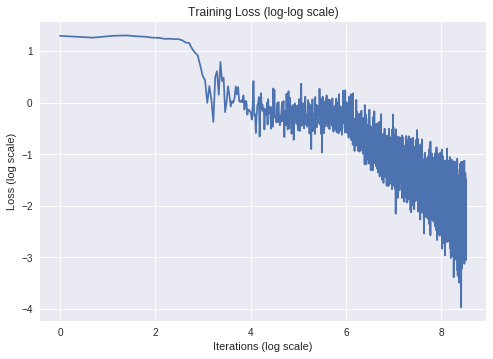

In [0]:
plt.plot(np.log(np.arange(len(loss_history))+1), np.log(1e-8+np.array(loss_history)))
plt.title('Training Loss (log-log scale)')
plt.xlabel('Iterations (log scale)')
plt.ylabel('Loss (log scale)')
plt.show()

## Save animation as a gif, download and display it

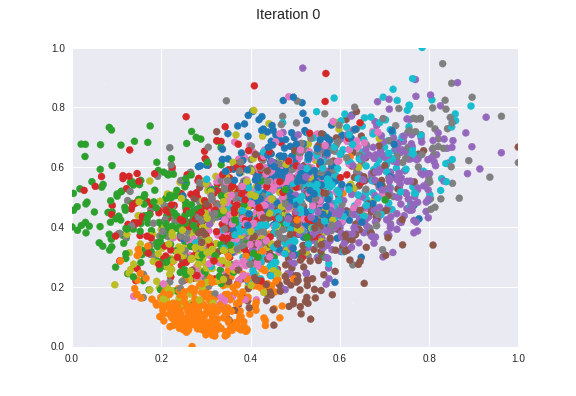

In [0]:
ani = makeAnimation(scatter_progression)

ani.save('metric_learning.gif', animation.ImageMagickFileWriter())
files.download("metric_learning.gif")
!mv metric_learning.gif metric_learning.png
ipyDisp.Image('metric_learning.png')